# Laboratorio 7
**Simulated Annealing using GROMACS**


Authors:
    
- Prof. Marco A. Deriu (marco.deriu@polito.it)
- Lorenzo Pallante (lorenzo.pallante@polito.it)
- Eric A. Zizzi (eric.zizzi@polito.it)
- Marcello Miceli (marcello.miceli@polito.it)
- Marco Cannariato (marco.cannariato@polito.it)

# Table of Contents

1. Introduction to Simulated Annealing 
2. Setting up the simulation
3. Simulation
4. Data Analysis and comments

**Learning outcomes:** 
- familiarizing with the SA techniques
- awareness of SA strengths and weaknesses
- GROMACS:
    - create an mdp file for SA
    - setting up the simulation using GROMACS
    - performing and analyzing the simulation

In [ ]:
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 100000000})

In [3]:
# IF YOU ARE USING COLAB EXECUTE THE FOLLOWING CELLS (to copy over data repository, install and enable the necessary packages)
!git clone https://github.com/lorenzopallante/BiomeccanicaMultiscala.git
!mv BiomeccanicaMultiscala/LAB/07-SimulatedAnnealing/* .

Clone in 'BiomeccanicaMultiscala' in corso...
remote: Enumerating objects: 1284, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (42/42), done.
^Ccezione degli oggetti:   1% (17/1284), 6.31 MiB | 6.29 MiB/s
fetch-pack: unexpected disconnect while reading sideband packet
zsh:1: no matches found: BiomeccanicaMultiscala/LAB/07-SimulatedAnnealing/*


In [ ]:
!pip install nglview &> /dev/null
!pip install simpletraj &> /dev/null
!apt install ghostscript &> /dev/null
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
#@title Installing DSSP
!apt install dssp &> /dev/null
!ln -s /usr/bin/dssp /usr/local/bin/dssp

In [ ]:
#@title Installing GROMACS
!apt install gromacs &> /dev/null

# Introduction to Simulated Annealing

First of all, what does the term **"annealing"** refer to?<br>
Annealing is the process in which the temperature of a molten substance is slowly reduced until the material crystallises to give a large single crystal. This process is widely used in many areas of manufacture, and a key feature of annealing is the use of very careful temperature control at the liquid-solid phase transition. <u>The perfect crystal that is eventually obtained corresponds to the global minimum of the free energy</u>.<br>
Simulated annealing is **a computational method that mimics this process in order to find the 'optimal' or 'best' solutions** to problems which have a large number of possible solutions [Kirkpatrick et al. 1983].

In simulated annealing, a cost function takes the role of the free energy in physical annealing and a control parameter corresponds to the temperature. To use simulated annealing in conformational analysis the cost function would be the internal energy. <u>At a given temperature the system is allowed to reach 'thermal equilibrium' using a molecular dynamics simulation</u>:
* At high temperatures, the systern is able to occupy high-energy regions of conformational space and to pass over high energy barriers
* At lower temperatures, the lower energy states becomes more probable in accordance with the Boltzmann distribution.
* At absolute zero, the system should occupy the lowest-energy state (i.e. the global minimum energy conformation). 

<img src="imgs/simulated_annealing.png" width="1500" align="center">

To guarantee that the globally optimal solution is actually reached would require an <u>infinite number of temperature steps</u>, at each of which the system would have to come to thermal equilibrium. Careful temperature control is required when the energy of the system is comparable with the height of the barriers that separate one region of conformational space from another. 

This is often difficult to achieve in practice and so simulated annealing cannot guarantee to find the global minimum, much as a genetic algorithm cannot guarantee to identify the globally optimal solution. However, if the same answer is obtained from several different runs then there is a high probability that it corresponds to the true global minimum. Several simulated annealing runs may enable a series of low-energy conformations of a molecule to be obtained.

## Setting up the simulation

Let's dive into an example of SA simulation setup using GROMACS.<br>
First of all, the general system setup (box configuration, solvation, neutralization, energy minimization, ...) will be exactly the same as we've seen for plain MD simulations, so we won't go into details again.

Let's just review our MD scheme again and perform the initial steps to obtain a minimized system

<img src="imgs/MD_FlowChart.png" width="500" align="center">

In [4]:
# First, a quick peek at the system using NGLView:
import nglview as nv
from IPython.display import IFrame
# Make sure that the path to penetratin.pdb matches your paths if you're using Colab!
with open("data/penetratin.pdb") as f:
    view = nv.show_file(f, ext="pdb")
view

NGLWidget()

In [66]:
# Some subfolders to keep stuff tidy
!mkdir -p 00-systemsetup 01-minimization 02-equilibration 03-production 04-annealing
# Let's create an index file as before:
!echo -e "q \n" | gmx make_ndx -f data/penetratin.pdb -o 00-systemsetup/index.ndx > /dev/null 2>&1

In [51]:
%%bash
# Topology generation:
cd 00-systemsetup
gmx pdb2gmx -f ../data/penetratin.pdb -i penetratin_posre.itp -p penetratin.top -o penetratin.gro -ff amber99sb-ildn  -ignh -heavyh -water tip3p > /dev/null 2>&1
cd ..

In [52]:
# Create simulation box:
!gmx editconf -f 00-systemsetup/penetratin.gro -o 00-systemsetup/box.gro -c -d 0.8 -bt dodecahedron > /dev/null 2>&1

In [53]:
# Solvation:
!gmx solvate -cp 00-systemsetup/box.gro -cs spc216.gro -o 00-systemsetup/solvated.gro -p 00-systemsetup/penetratin.top > /dev/null 2>&1

In [54]:
# Quick peek:
import nglview as nv
with open("00-systemsetup/solvated.gro") as f:
    view = nv.show_file(f, ext="gro")
view.add_ball_and_stick(selection="water")
view.camera = 'orthographic'
view

NGLWidget()

In [55]:
# Neutralize:
!touch 00-systemsetup/dummy.mdp
!gmx grompp -f 00-systemsetup/dummy.mdp -c 00-systemsetup/solvated.gro -p 00-systemsetup/penetratin.top -o 00-systemsetup/ions.tpr > /dev/null 2>&1
!echo "SOL" | gmx genion -s 00-systemsetup/ions.tpr -p 00-systemsetup/penetratin.top -o 00-systemsetup/box_ions.gro -conc 0.15 -neutral > /dev/null 2>&1
with open("00-systemsetup/box_ions.gro") as f:
    view = nv.show_file(f, ext="gro")
view.add_licorice(selection="water")
view.add_ball_and_stick(selection="NA",color='blue',aspectRatio='5') 
view.add_ball_and_stick(selection="CL",color='green',aspectRatio='5')
view.camera = 'orthographic'
view


NGLWidget()

### Energy Minimization

In [56]:
# Energy minimization:
!gmx grompp -f data/mdp/em.mdp -p 00-systemsetup/penetratin.top -c 00-systemsetup/box_ions.gro -o 01-minimization/em.tpr  > /dev/null 2>&1
!gmx mdrun -s 01-minimization/em.tpr -deffnm 01-minimization/em -v -ntmpi 2

                      :-) GROMACS - gmx mdrun, 2021.3 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teemu Mur

### Position-restrained NVT equilibration

In [58]:
# Initial equilibration: (CAN BE SLOW ON COLB! SEE BELOW!)
!gmx grompp -f data/mdp/posre.mdp -c 01-minimization/em.gro -r 01-minimization/em.gro -p 00-systemsetup/penetratin.top -o 02-equilibration/posres.tpr  -maxwarn 2 > 02-equilibration/grompp.log 2>&1
!gmx mdrun -s 02-equilibration/posres.tpr -deffnm 02-equilibration/posres -v  > 02-equilibration/mdrun.log 2>&1

                      :-) GROMACS - gmx mdrun, 2021.3 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teemu Mur

In [ ]:
# NOTE: The cell above (equilibration) might take a substantial amount of time on COLAB. To speed things up for the lesson, you can instead retrieve the 
# pre-computed trajectory from the repository using the following command:
!gdown --folder https://drive.google.com/drive/folders/1ymVZ2dV2-L3RPu9TNkAVKMVux0xByfip?usp=share_link > /dev/null 2&>1

### Production plain MD simulation

In [61]:
# Quick production MD run (CAN BE SLOW ON COLB! SEE BELOW!):
!gmx grompp -f data/mdp/md.mdp -c  02-equilibration/posres.gro -p 00-systemsetup/penetratin.top -o 03-production/md.tpr >03-production/grompp.log 2>&1 
!gmx mdrun -deffnm 03-production/md -s 03-production/md.tpr -v > 03-production/mdrun.log 2>&1
# Fix PBCs:
! echo -e "0 \n" | gmx trjconv -s 03-production/md.tpr -f 03-production/md.xtc -pbc mol -ur compact -o 03-production/noPBC.xtc  > /dev/null 2&>1

In [ ]:
# NOTE: The cell above (md simulation) might take a substantial amount of time on COLAB. To speed things up for the lesson, you can instead retrieve the 
# pre-computed trajectory from the repository using the following command:
!gdown --folder https://drive.google.com/drive/folders/1LCB9BbwfldN6JzzVKF7d6s_Ysr1BkvgH?usp=share_link &> /dev/null

In [65]:
# Let's have a final look:
import nglview as nv
traj_nopbc = nv.SimpletrajTrajectory("03-production/noPBC.xtc", "03-production/md.gro")
view_nopbc = nv.show_simpletraj(traj_nopbc)
view_nopbc.add_representation("ball+stick",selection="water")
view_nopbc.center("sytem")
view_nopbc.camera = 'orthographic'
view_nopbc

NGLWidget(max_frame=2500)

## Setup the Simulated Annealing

Now, let's have a look at the parameters we need to set.<br>
First, a small but crucial technical note: the annealing is implemented in GROMACS by changing the current reference temperature for each group in the temperature coupling. This means that **the actual relaxation and coupling properties depends on the type of thermostat** you use and how hard you are coupling it. Since we are changing the reference temperature it is important to remember that <u>the system will NOT instantaneously reach this value</u> - you need to allow for the inherent relaxation time in the coupling algorithm too!<br>
**If you are changing the annealing reference temperature faster than the temperature relaxation you will probably end up with a crash when the difference becomes too large.**

Suppose we want to impose the following annealing protocol over 2 ns of simulation:

| Time (ps) | Ref. T (K) |
|-----------|------------|
| 0         | 303        |
| 500       | 303        |
| 501       | 500        |
| 1000      | 500        |
| 1001      | 1100       |
| 1500      | 1100       |
| 1501      | 303        |
| 2000      | 303        |

How do we implement this?<br>
The annealing protocol is specified as a <u>series of corresponding times and reference temperatures <b>for each group</b></u>, and you can also choose whether you only want a single sequence (after which the temperature will be coupled to the last reference value), or if the annealing should be periodic and restart at the first reference point once the sequence is completed.
<div class="alert alert-block alert-warning"> NOTE: you can mix and match both types of annealing and non-annealed groups in your simulation! </div>


Technically, the reference temperature is a **piecewise linear function**. The actual annealing is performed by dynamically changing the reference temperature used in the thermostat algorithm selected, so remember that the system will usually not instantaneously reach the reference temperature!

| MDP Option        | Setting Options | Function                                                                                                                                                                                                                                                                                                                                                             |
|-------------------|-----------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Annealing         | no              | No simulated annealing - just couple to reference temperature value.                                                                                                                                                                                                                                                                                                 |
|                   | single          | A single sequence of annealing points. If your simulation is longer than the time of the last point, the temperature will be coupled to this constant value after the annealing sequence has reached the last time point.                                                                                                                                            |
|                   | periodic        | The annealing will start over at the first reference point once the last reference time is reached. This is repeated until the simulation ends.                                                                                                                                                                                                                      |
| annealing-npoints |                 | A list with the number of annealing reference/control points used for each temperature group. Use 0 for groups that are not annealed. The number of entries should equal the number of temperature groups.                                                                                                                                                           |
| annealing-time    |                 | List of times at the annealing reference/control points for each group. If you are using periodic annealing, the times will be used modulo the last value,  i.e.  if the values are 0, 5, 10, and 15, the coupling will restart at the 0ps value after 15ps, 30ps, 45ps, etc. The number of entries should equal the sum of the numbers given in  annealing-npoints. |
| annealing-temp    |                 | List of temperatures at the annealing reference/control points for each group. The number of entries should equal the sum of the numbers given in  annealing-npoints.                                                                                                                                                                                                |

## Example
Assume we have two temperature groups (water and non-water).
Let's set:
* the group selections to:                  annealing = single single
* the number of points of each group to:    annealing-npoints = 3 3
* the times to:                             annealing-time = 0 100 500 0 100 500
* the temperatures to:                      annealing-temp = 303 500 303 303 500 303 

The first group will be coupled to 303K at 0ps, and the reference temperature will increase linearly to reach 500K at 100ps, and then linearly between 500K and 303K again from 100ps to 500ps. **After this it stays constant**, at 303K. The second group is coupled in exactly the same way (notice that the values are repeated in the mdp sequences).<br>
REMEMBER: Check the summary printed by gmx grompp if you are unsure!

## Exercise:
Using the example above and the table of reference temperature values to be reached, edit the mdp file "data/mdp/md_annealing.mdp" to setup such a simulation.

## Running the SA

In [1]:
# We will use the previous equilibrated MD structure as a starting point (we equilibrated it at 303K) (WARNING: SLOW ON COLAB!)!
!gmx grompp -f data/mdp/md_annealing.mdp -c  03-production/md.gro -p 00-systemsetup/penetratin.top -o 04-annealing/annealing.tpr >04-annealing/grompp.log 2>&1 
!gmx mdrun -deffnm 04-annealing/annealing -s 04-annealing/annealing.tpr -v -nt 12 > 04-annealing/mdrun.log 2>&1
# Fix PBCs:
! echo -e "0 \n" | gmx trjconv -s 04-annealing/annealing.tpr -f 04-annealing/annealing.xtc -pbc mol -ur compact -o 04-annealing/noPBC.xtc  > /dev/null 2>&1
# NOTICE HOW WE ARE USING STDOUT AND STDERR REDIRECTION TO WRITE SOME LOG FILES FOR INSPECTION!

In [ ]:
# NOTE: The cell above (SA simulation) might take a substantial amount of time on COLAB. To speed things up for the lesson, you can instead retrieve the 
# pre-computed trajectory from the repository using the following command:
!gdown --folder https://drive.google.com/drive/folders/1x3dGPJKEnvktCk8GvzEHVnvUPI1Snubo?usp=share_link &> /dev/null

# Data Analysis and Comments

We now have the output simulation files for our SA simulation.<br>
As a first thing, let's fix the PBCs and have a look at the simulation (you can use VMD or the NGLView snippet below)

In [ ]:
# Let's have a final look:
import nglview as nv
traj_nopbc = nv.SimpletrajTrajectory("04-annealing/noPBC.xtc", "04-annealing/annealing.gro")
view_nopbc = nv.show_simpletraj(traj_nopbc)
view_nopbc.add_representation("none",selection="water")
view_nopbc.center("sytem")
view_nopbc.camera = 'orthographic'
view_nopbc

The trajectory looks ok, but it's a bit hard to get a grasp of what's going on by just looking at it.<br>
So as a first thing, let's check that the time evolution of the system temperature actually follows what we wanted to impose:

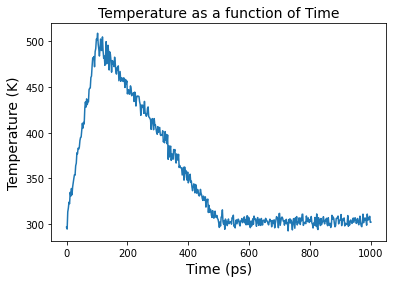

In [3]:
! echo -e "Temperature \n 0\n" | gmx energy -f 04-annealing/annealing.edr -o 04-annealing/temperatures.xvg > /dev/null 2>&1
# Some python magic for plotting:
import matplotlib.pyplot as plt
import numpy as np
data = np.loadtxt("04-annealing/temperatures.xvg",skiprows=24)
plt.plot(data[:,0],data[:,1])
plt.xlabel("Time (ps)",size=14)
plt.ylabel("Temperature (K)",size=14)
plt.title("Temperature as a function of Time",size=14)
plt.show() 

The temperatures look ok, but what about the reason we used SA to begin with? Remember, the goal was to somehow use thermal (i.e. kinetic) energy to get out of local energy minima.<br>
In practice this might mean that we sampled a wider range of protein conformations during our simulation (if compared to plain MD).<br>
One technique that might be useful to assess the conformational variability is **clustering**.

## Clustering

A very quick recap on clustering:<br>
In very simple terms, think of clustering as a way to group similar elements into collections (named "clusters") which are assembled in such a way that elements within clusters ("members") are highly similar, and elements from two different clusters are increasingly dissimilar.<br>
This means that to perform clustering you first of all need to define what is similar and what is not, and be able to quantify this. This is what's called a **similarity metric**.<br>
You can think of many different ways to define similarity between two elements based on what you are trying to cluster:
* the euclidean distance between a set of points
* the plain difference between two numerical variables (perhaps it might be useful to take the abs. value or the root of the square...)
* the tanimoto coefficient between sets of molecules
* etc...

## Question: 
In the molecular modelling world, can you think of a metric that defines the "similarity" between two molecular structues?

You guessed it, the **RMSD**<br>
Let's take a look at our gif again:
<img src="imgs/SupplementaryAnimationRMSD.gif" width="1500" align="center">

As you can see, the RMSD can be very useful to define how "similar" two snapshots (e.g. two frames) of a given molecular structure are.<br>
So if we want to cluster a bunch of snapshots, a naive but effective approach might be something like:
* Take the first snapshot and make it the only member of the first cluster (initialization)
* Take the second snapshot, overlap it with the first one (as in the gif above), calculate the RMSD between the two:
  * if this value is below a given threshold (e.g., 1 Angstrom), then add the second snapshot to the cluster (which until now only contained the first snapshot)
  * if this value is above the threshold, then this second snapshot becomes a new cluster (with just itself in it, for now)
* Suppose we took the first option, now we have one single cluster with two snapshots in it
* Now we look at the third snapshot, what RMSD do we calculate? There are different options:
  * RMSD between this third snapshot and both members of the cluster (= the first two snapshots), then we average the two values
  * We first calculate an "average structure" of the two members of the cluster, and then calculate the RMSD between the current (third) snapshot and this average structure
  * ...any more ideas?
* ...and then we keep going, iteratively, as above, until we processed all the snapshots

As you might guess, the more the snapshots remain similar throughout the simulation (=<u><b>conformational stability</u></b>), the less clusters we will end up with, because all the frames will end up in the same cluster(s)

## Question
Let's go back to our SA simulation. Remember, the goal was to play around with the thermal (kinetic) energy to be able to overcome energy barriers keeping our protein stuck in a local minimum and explore a wider portion of the phase space.<br>
If you were to compare the outcomes of a clustering analysis of **the same system** in two cases:
* Plain MD
* Simulated Annealing 

what differences do you expect?

Let's do this analysis on our simulations and check out the results:

In [ ]:
# IF YOU DOWNLOADED PRE-CALCULATED RESULTS, EXECUTE THIS CELL (FOR GROMACS VERSION COMPATIBILITY):
!gmx grompp -f data/mdp/md.mdp -c  02-equilibration/posres.gro -p 00-systemsetup/penetratin.top -o 03-production/md.tpr >03-production/grompp18.log 2>&1 
!gmx grompp -f data/mdp/md_annealing.mdp -c  03-production/md.gro -p 00-systemsetup/penetratin.top -o 04-annealing/annealing.tpr >04-annealing/grompp.log 2>&1 

In [4]:
!mkdir -p 05-analysis
# We will use the cluster analysis tool from GROMACS:
!gmx cluster -h


                     :-) GROMACS - gmx cluster, 2021.3 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teemu Mu

In [19]:
# Do the clustering on both the plain MD and the SA simulations:
!echo -e "Protein\nProtein\n" | gmx cluster -s 03-production/md.tpr -f 03-production/md.xtc -cl 05-analysis/clusterMD.pdb -cutoff 0.15 -o 05-analysis/clusterMD.xpm -g 05-analysis/clusterMD.log -dt 1 -dist 05-analysis/rmsd-distMD.xvg > /dev/null 2>&1
!echo -e "Protein\nProtein\n" | gmx cluster -s 04-annealing/annealing.tpr -f 04-annealing/annealing.xtc -cl 05-analysis/clusterSA.pdb -cutoff 0.15 -o 05-analysis/clusterSA.xpm -g 05-analysis/clusterSA.log -dt 1 -dist  05-analysis/rmsd-distSA.xvg > /dev/null 2>&1

Here, we clustered both the plain MD trajectory and the simulated annealing trajectory, using the same settings and the same cutoff. First of all, let's have a look at how many clusters were found. This information is written in the log files:

In [23]:
!echo "*** Molecular Dynamics Clustering: ***"
!head -n 8 05-analysis/clusterMD.log
!echo "*** Simulated Annealing Clustering: ***"
!head -n 8 05-analysis/clusterSA.log

*** Molecular Dynamics Clustering: ***
Using linkage method for clustering
Using RMSD cutoff 0.15 nm
The RMSD ranges from 0.0530823 to 0.2094 nm
Average RMSD is 0.134276
Number of structures for matrix 51
Energy of the matrix is 0.250216.

Found 1 clusters
*** Simulated Annealing Clustering: ***
Using linkage method for clustering
Using RMSD cutoff 0.15 nm
The RMSD ranges from 0.0633693 to 0.655419 nm
Average RMSD is 0.351793
Number of structures for matrix 501
Energy of the matrix is 5.34739.

Found 15 clusters


We already see that plain MD yielded 1 cluster at 0.15 nm cutoff, whereas SA yielded a whopping 337 clusters! Indeed, the conformation of the peptide is much more variable (in terms of RMSD) in the SA, thanks to the added thermal driving force! 
Let's have a look at the two structures:

In [24]:
# Here we have a single cluster, and only the central structure of the cluster is saved, so we can have a look at it with nglview:
import nglview as nv
from IPython.display import IFrame

with open("05-analysis/clusterMD.pdb") as f:
    view = nv.show_file(f, ext="pdb")
view

NGLWidget()

In [32]:
# In this case, the central structure of each of the 337 clusters is written to a single PDB file. By tweaking the NGLView settings we can see them all at once:
import nglview as nv
with open("05-analysis/clusterSA.pdb") as f:
    view = nv.show_file(f, ext="pdb",default_representation=False)
    view.add_representation("cartoon",selection="protein",color="modelindex")
view

NGLWidget()

As you can see we confirmed that performing simulated annealing allowed us to get an improved sampling of the different energy minima.<br>
Of course, by increasing the simulation time and the temperatures you can aim for an even wider exploration of the different conformations of a given molecular system.<br>
<div class="alert alert-block alert-warning"> NOTE: be aware that even if the final temperature is the same as the starting one, it is very much likely that the final structure will be different from the starting one! Can you formulate a hypothesis as to why this occurs? </div>

## Ramachandran Plots

Just as for plain MD simulations, we can analyse the Ramachandran plots for the different snapshots of an SA simulation to see what's going on with the peptide geomtry:

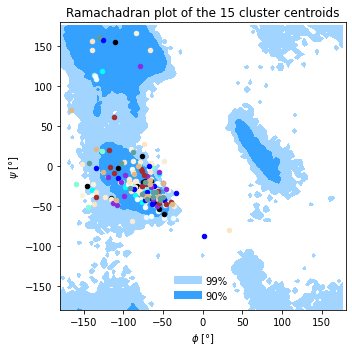

In [60]:
import matplotlib
# Perform the analysis:
!gmx rama -f 05-analysis/clusterSA.pdb -s 04-annealing/annealing.tpr -o 05-analysis/ramaSA.xvg > /dev/null 2>&1
# Load data
# You have to load separately floating point numbers and string
phi, psi = np.loadtxt('05-analysis/ramaSA.xvg',comments=['@','#'],usecols=(0,1),unpack=True)
residues = np.loadtxt('05-analysis/ramaSA.xvg',comments=['@','#'],usecols=(2),dtype=str)

# This line searches all the points in the array where the first residue of the protein is present
# Therefore, it contains the information to separate information of different frames
delimiters = np.squeeze(np.argwhere(residues == residues[0]))
from matplotlib.lines import Line2D # For the legend
from MDAnalysis.analysis.data.filenames import Rama_ref
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,)
# Generate points in the plane to plot the Ramachandran regions
# THESE X,Y POINTS ARE CREATED IN ORDER TO BE COHERENT WITH DATA IN Rama_ref
# DO NOT MODIFY
X, Y = np.meshgrid(np.arange(-180, 180, 4), np.arange(-180, 180, 4))
Z = np.load(Rama_ref)
# THE NUMBERS ON LEVELS ARE DEFINED TO PLOT THE ALLOWED AND GENEROUSLY ALLOWED REGIONS
# DO NOT MODIFY
c = ax.contourf(X, Y, Z, levels=[1, 17, 15000],colors = ['#A1D4FF', '#35A1FF'])

# CHANGE THIS VARIABLE TO REFLECT HOW MANY CLUSTERS YOU HAVE
Nclust=15
# ----------------------------------------------------------
frames = range(0,Nclust+1)
# Get Nclust colors:
colors=list(matplotlib.colors.cnames.keys())[0:Nclust-1]
for col,frame in zip(colors,frames):
    ax.scatter(phi[delimiters[frame]:delimiters[frame+1]],psi[delimiters[frame]:delimiters[frame+1]],
              marker='o',s=20,c=col)

# Set the limits of torsional angles
ax.set_xlim(-180,180)
ax.set_ylim(-180,180)
ax.set_xlabel(r"$\phi$ [°]")
ax.set_ylabel(r"$\psi$ [°]")
ax.set_title("Ramachadran plot of the 15 cluster centroids")
#Personalize it with a legend
custom_lines = [Line2D([0], [0], color='#A1D4FF', lw=8),
                Line2D([0], [0], color='#35A1FF', lw=8)]
ax.legend(custom_lines, ['99%', '90%'],loc='lower center',frameon=False)
fig.tight_layout()

Do you notice anything in this plot? What are your thoughts and comments?

## DSSP / Secondary Structure

Again, we can also use DSSP secondary structure analysis to try and see if the secondary structure is altered, and how so, during the SA simulation. We will use exactly the same procedure we used before for the plain MD simulation.

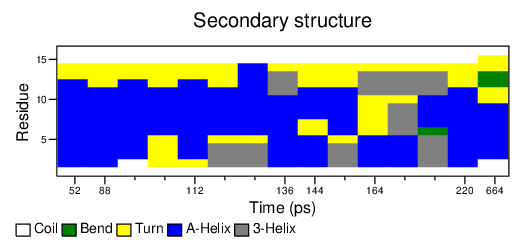

In [68]:
# Let's do the SS analysis:
!echo -e "Protein\n" | gmx do_dssp -s 04-annealing/annealing.tpr -f 05-analysis/clusterSA.pdb -o 05-analysis/ssSA.xpm -dt 50 > /dev/null 2>&1
# Some XPM settings:
!echo -e "; Command line options of xpm2ps override the parameters in this file\nxbox                     = 30.0          ; x-size of a matrix element\nybox                     = 8.0          ; x-size of a matrix element\ny-major                  = 5            ; y major ticks\ny-minor                  = 0\n" > 05-analysis/options.m2p
!gmx xpm2ps -f 05-analysis/ssSA.xpm -di 05-analysis/options.m2p -o 05-analysis/ssSA.eps > /dev/null 2>&1
# Convert to png and display:
!convert 05-analysis/ssSA.eps 05-analysis/ssSA.png
# Show png in notebook:
from IPython.display import Image
Image(filename='05-analysis/ssSA.png')

In [ ]:
# IF YOU ARE ON COLAB, USE THIS CELL TO VISUALIZE THE PLOT:
def convert_image(f="plot.eps",o="plot.png"):
    '''
    Function that allows you to convert a file from esp format to png format
    '''
    from PIL import Image
    eps_image = Image.open(f)
    eps_image.load(scale=10)
    eps_image.save(o)

convert_image(f="05-analysis/ssSA.eps",o="05-analysis/ssSA.png")
# Show png in notebook:
from IPython.display import Image
Image(filename='05-analysis/ssSA.png')

In [ ]:
# IF YOU ARE ON YOUR OWN PC, USE THIS CELL TO VISUALIZE THE PLOT:
!convert 05-analysis/ssSA.eps 05-analysis/ssSA.png
from IPython.display import Image
Image(filename='05-analysis/ssSA.png')

What do you notice here? Any comments?